In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

In [11]:
x=np.arange(0,12).reshape(3,4)
y=np.array([True,False,True])
print(y)
print(x)
print("-"*50)

print(x[y])
print(x[y,1])   # 先按行筛选，然后取第1列
print(type(x[y,1]))
print(x[y,1].shape)

[ True False  True]
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]
--------------------------------------------------
[[ 0  1  2  3]
 [ 8  9 10 11]]
[1 9]
<class 'numpy.ndarray'>
(2,)


(50000, 2)
(50000,)
[0 1]
[1 0 0 0 1 1 0 1 0 1]


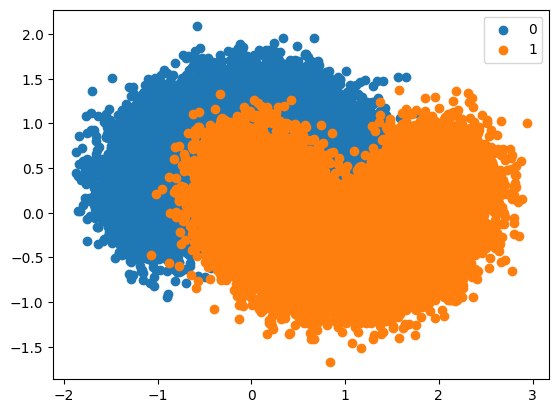

In [23]:
# x是特征，y是标签
x, y = datasets.make_moons(n_samples=50000, noise=0.3, random_state=42)
print(x.shape)
print(y.shape)
print(np.unique(y))
print(y[:10])


plt.scatter(x[y == 0, 0], x[y == 0, 1]) # 拿到样本中标签为0的第0列特征，第1列特征
plt.scatter(x[y == 1, 0], x[y == 1, 1]) # 拿到样本中标签为1的第0列特征，第1列特征
plt.legend(['0', '1'])
plt.show()  #图形的点颜色是自动的

In [24]:
#选样本中标签为0的那些样本的，第零列特征
print(x[y == 0, 0])
print(x[y == 0])

[ 0.11096372  0.61562814  0.46175947 ...  0.27571831  0.90929791
 -0.97512015]
[[ 0.11096372  1.10964541]
 [ 0.61562814 -0.06539887]
 [ 0.46175947  1.17926518]
 ...
 [ 0.27571831  1.03299749]
 [ 0.90929791 -0.09962261]
 [-0.97512015  0.87195198]]


In [25]:
x

array([[ 0.71820567, -0.21809028],
       [ 0.11096372,  1.10964541],
       [ 0.61562814, -0.06539887],
       ...,
       [ 1.58004352, -0.3637176 ],
       [ 0.90929791, -0.09962261],
       [-0.97512015,  0.87195198]])

In [26]:
# 默认分割比例是75%和25%
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

### 逻辑回归

In [27]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression()
log_clf.fit(x_train, y_train)
log_clf.score(x_test, y_test)

0.85336

### 支持向量机

In [28]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(x_train, y_train)
svm_clf.score(x_test, y_test)

0.91216

### 决策树

In [29]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier()
dt_clf.fit(x_train, y_train)
dt_clf.score(x_test, y_test)

0.87576

# 1 手动实现投票分类器

In [30]:
# 训练好模型，测试集做预测
y_predict1 = log_clf.predict(x_test)
y_predict2 = svm_clf.predict(x_test)
y_predict3 = dt_clf.predict(x_test)

In [31]:
# 纯手动bagging，硬投票
y_predict = np.array((y_predict1 + y_predict2 + y_predict3) >= 2, dtype='int')
print(y_predict[:10])

[1 1 1 0 0 0 0 0 0 1]


In [34]:
print(y_test[:10])

[1 1 1 0 0 0 0 1 0 1]


In [36]:
from sklearn.metrics import accuracy_score

#accuracy_score计算准确率的
accuracy_score(y_test, y_predict)

0.9048

# 2 集成学习VotingClassifier(并行)

In [37]:
from sklearn.ensemble import VotingClassifier

# hard模式就是硬投票，只考虑谁多谁少
voting_clf = VotingClassifier(estimators=[
    ('log_clf', LogisticRegression()),
    ('svm_clf', SVC()),
    ('dt_clf', DecisionTreeClassifier())],
    voting='hard')

In [38]:
voting_clf.fit(x_train, y_train)
voting_clf.score(x_test, y_test)

0.90448

更合理的投票，应该有权值
唱歌比赛的投票(评委的投票权重与观众不一样)

In [39]:
# 软投票，考虑权重
voting_clf2 = VotingClassifier(estimators=[
    ('log_clf', LogisticRegression()),
    ('svm_clf', SVC(probability=True)),  #支持向量机中需要加入probability，这样计算结果才会附带概率
    ('dt_clf', DecisionTreeClassifier())], voting='soft')
# 决策树已经自带概率，比如一个叶子结点，4人存活1人不存活，则存活概率是0.8

voting_clf2.fit(x_train, y_train)
voting_clf2.score(x_test, y_test)


0.9036

# 使用bagging

In [42]:
50000*0.75  # 训练集的样本数

37500.0

In [40]:
from sklearn.tree import DecisionTreeClassifier  #用决策树集成上千模型
from sklearn.ensemble import BaggingClassifier

# 300棵决策树，bootstrap是有放回抽样，max_samples不可以超过训练集的数目37500
# 每棵树的训练样本数量最多是3000个，且每棵树的样本各不相同。
# 这是通过自助采样（bootstrap sampling），即有放回的随机抽样来实现的。
bagging_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=300,
                                max_samples=3000, bootstrap=True)
bagging_clf.fit(x_train, y_train)
bagging_clf.score(x_test, y_test)

0.91256

# 3 oob设计
### 有放回抽样，平均37%的样本不会被抽取到训练
### 拿没有取到的样本作为验证集

In [43]:
bagging_clf2 = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100,
                                 bootstrap=True,
                                 oob_score=True)
bagging_clf2.fit(x_train, y_train)
bagging_clf2.oob_score_  # 在测试集之前就可以得到一个准确率

0.9114933333333334

In [44]:
bagging_clf2.score(x_test, y_test)

0.91008

### njobs

In [3]:
from sklearn.tree import DecisionTreeClassifier  #用决策树集成上千模型
from sklearn.ensemble import BaggingClassifier

In [45]:
%%time
bagging_clf = BaggingClassifier(DecisionTreeClassifier(),
                                n_estimators=500, max_samples=2000,
                                bootstrap=True) # 因为每次抽到的样本不一定相同，所以准确率不同
bagging_clf.fit(x_train, y_train)
bagging_clf.score(x_test, y_test)
#cpu time是实际cpu运行算法时间，wall time是墙上真实时间，就是real time（包含了进程启动时间，I/O等待时间等）

CPU times: total: 7.59 s
Wall time: 7.91 s


0.91168

In [46]:
%%time
#多核使用的时间更小, %%time要顶格来写
bagging_clf = BaggingClassifier(DecisionTreeClassifier(),
                                n_estimators=500, max_samples=2000,
                                bootstrap=True, n_jobs=-1)
bagging_clf.fit(x_train, y_train)
bagging_clf.score(x_test, y_test)

CPU times: total: 500 ms
Wall time: 4.44 s


0.91184

# 4 bootstrap_features  对特征进行采样
### 比如100个特征，也许我抽出的50个特征刚好是重要的。就是增大了随机性

In [47]:
#因为我们就两个特征，所以max_features设置为1,得到的分值较低是因为我们特征较少，采用随机特征不合适
#这个是只对特征进行采样
random_subspaces_clf = BaggingClassifier(DecisionTreeClassifier(),
                                         n_estimators=500, max_samples=500, oob_score=True,
                                         bootstrap=True, n_jobs=-1,
                                         max_features=1, bootstrap_features=True)
random_subspaces_clf.fit(x, y)
random_subspaces_clf.oob_score_

0.88546

In [50]:
print(x.shape)
print(x_train.shape)
print(y.shape)

(50000, 2)
(37500, 2)
(50000,)


In [48]:
# 这里是为了验证总的抽样的样本数不能大于训练集的数目
random_patches_clf = BaggingClassifier(DecisionTreeClassifier(),
                                       n_estimators=500, max_samples=50001, oob_score=True,
                                       bootstrap=True, n_jobs=-1,
                                       max_features=1, bootstrap_features=True)
random_patches_clf.fit(x, y)
random_patches_clf.oob_score_
#这个代码有另外一个名字就是随机森林

ValueError: max_samples must be <= n_samples

## 随机森林也是一种并行的集成学习方法，基分类器只能是决策树

In [51]:
from sklearn.ensemble import RandomForestClassifier

In [52]:
%%time

rc_clf = RandomForestClassifier(n_estimators=500, random_state=666,
                                oob_score=True, n_jobs=-1)
rc_clf.fit(x, y)
rc_clf.oob_score_

CPU times: total: 2min 8s
Wall time: 21.2 s


0.90322

In [41]:
%%time
rc_clf = RandomForestClassifier(max_samples=37500, n_jobs=-1)
rc_clf.fit(x_train, y_train)
rc_clf.score(x_test, y_test)

CPU times: total: 8.03 s
Wall time: 1.53 s


0.90296

In [43]:
%%time
#max_leaf_nodes 最大的叶子结点数
rc_clf2 = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16,
                                 random_state=666,
                                 oob_score=True, n_jobs=-1)
rc_clf2.fit(x, y)
rc_clf2.oob_score_

CPU times: total: 32.5 s
Wall time: 8.71 s


0.90962

# 5 Extra-Trees
### 非常随机，阈值、高度等参数都是随机的。防止过拟合，降低方差，但是偏差变大
ExtraTreesClassifier 是一种机器学习算法，属于基于决策树的集成方法家族。
它随机选择特征子集和数据样本来构建多个决策树，并将它们的预测聚合起来做出最终预测。
它可用于分类任务，并以处理嘈杂和高维数据的能力而闻名。

In [53]:
from sklearn.ensemble import ExtraTreesClassifier

et_clf = ExtraTreesClassifier(n_estimators=500, oob_score=True,
                              bootstrap=True, n_jobs=-1)
et_clf.fit(x, y)
et_clf.oob_score_

0.90616

# Boosting
# 5 串行（包含adaboost和GBDT）

In [55]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

### adaboost
可以指定基分类器，但是和前面手动投票不同，这里的基分类器只能是同一个

In [56]:
%%time
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(),
                             n_estimators=500)
ada_clf.fit(x_train, y_train)
ada_clf.score(x_test, y_test)


CPU times: total: 391 ms
Wall time: 459 ms


0.87656

## GBDT
基分类器只能是决策树

In [58]:
%%time
gb_clf = GradientBoostingClassifier(max_depth=3, n_estimators=500) # 增加了基分类器的数目后，准确率提升
gb_clf.fit(x_train, y_train)
gb_clf.score(x_test, y_test)

CPU times: total: 41.8 s
Wall time: 42.5 s


0.91192

In [3]:
import numpy as np

print(np.log(9))  #当错误率是0.1时权重是2.19
np.log((1-0.5)/0.5)  #当错误率是0.5时，权重是0

2.1972245773362196


0.0